In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalStationaryTransitions, HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions, \
    HierarchicalNeuralNetworkRecurrentTransitions, GroupRecurrentTransitions, ElaborateGroupRecurrentTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify hyperparameters
results_dir = "results/combined/2018-10-08"

In [3]:
with open(os.path.join(results_dir, "pca_D20.pkl"), "rb") as f:
    pca, xs_full = pickle.load(f)
    
D = 15
xs = [x[:,:D].copy('C') for x in xs_full]
Ts = [x.shape[0] for x in xs]
W = len(xs)

In [4]:
with open(os.path.join(results_dir, "z_trues.pkl"), "rb") as f:
    z_trues, z_true_key, z_map_kato, z_map_nichols = pickle.load(f)

In [5]:
with open(os.path.join(results_dir, "us.pkl"), "rb") as f:
    us = pickle.load(f)
    
# Convert u into o2 and do2s
# E[u] = 13.6678;  std[u] = 5.185
def u_to_features(u, nlags=9):
    o2 = (u - 13.6678) / 5.185
    do2 = np.concatenate(([0], np.diff(o2)))
    
    # Also add the smoothed do2
    f = np.exp(-np.arange(3 * 10) / (3 * 3))
    f /= f.sum()
    f_do2 = np.convolve(do2, f, mode="full")[:-len(f)+1]
    
    features = [o2, f_do2]
    return np.column_stack(features)

us = [u_to_features(u) for u in us]
M = us[0].shape[1]

In [6]:
groups = ["kato",
          "n2_prelet", 
          "n2_let",
          "npr1_prelet",
          "npr1_let"]

worms_and_groups = [(i, "kato") for i in range(5)] + \
                   [(i, "n2_1_prelet") for i in range(11)] + \
                   [(i, "n2_2_let") for i in range(12)] + \
                   [(i, "npr1_1_prelet") for i in range(10)] + \
                   [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(group, i) for (i, group) in worms_and_groups]

# Split into train/test/validation

In [7]:
np.random.seed(0)
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_xs = []
all_us = []
all_gs = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (x, u, tag, ztr) in enumerate(zip(xs, us, worms_and_groups, z_trues)):
    T = x.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_xs.append(x[start:stop].copy("C"))
        all_us.append(u[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_xs = get(all_xs, 0)
train_us = get(all_us, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_xs = get(all_xs, 1)
val_us = get(all_us, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_xs = get(all_xs, 2)
test_us = get(all_us, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

In [8]:
# Compute number of training, validation, and test entries
D_train = sum([x.size for x in train_xs])
D_val = sum([x.size for x in val_xs])
D_test = sum([x.size for x in test_xs])

print("D_train: ", D_train)
print("D_val:   ", D_val)
print("D_test:  ", D_test)

D_train:  1647105
D_val:    367170
D_test:   366345


# Fit an ARHMM to the continuous latent states, sweeping over number of discrete latent states

In [9]:
# Ks = np.arange(2, 21, step=2)
# transitionss = ["standard", "recurrent"]
# observationss = ["gaussian", "t", "ar", "robust_ar"]
# etas = [1e-1, 1e-2, 1e-3, 1e-4]

Ks = [12]
transitionss = ["recurrent"]
observationss = ["robust_ar"]
etas = [1e-1]

In [10]:
def _fit_hmm(K, transitions, observations):
    hmm = HMM(K, D, M, transitions=transitions, observations=observations)
    lps = hmm.fit(train_xs, inputs=train_us, method="em", num_em_iters=250)
    val_ll = hmm.log_likelihood(val_xs)
    return hmm, lps, val_ll

In [11]:
hmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hmm_results_name)(_fit_hmm)
            
            print("Fitting ", hmm_results_name)
            hmm_results[hmm_results_name] = fit(K, transitions, observations)
            
with open(os.path.join(results_dir, "hmm_results.pkl"), "wb") as f:
    pickle.dump(hmm_results, f)

Fitting  hmm_recurrent_robust_ar_K12


# Fit hierarchical HMMs

In [14]:
def _fit_hierarchical_hmm(K, eta, transitions, observations, hmm):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(recurrent=ElaborateGroupRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, worms_and_groups, M, eta1=eta, eta2=1e-1)
    assert transition_distn.T == len(worms_and_groups)
    assert transition_distn.G == 5
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, worms_and_groups, M, eta=eta)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, inputs=train_us, tags=train_tags, method="em", num_em_iters=250, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
    return hhmm, lps, val_ll

In [15]:
hhmm_results = {}
for K in Ks:
    for eta in etas:
        for transitions in transitionss:
            for observations in observationss:
                # Get the HMM results
                hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
                hmm, _, _ = hmm_results[hmm_results_name]

                # Fit the Hierarchical HMM
                hhmm_results_name = "hhmm_{}_{}_K{}_eta{:1.0e}".format(transitions, observations, K, eta)
                fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm)
                print("Fitting ", hhmm_results_name)
                hhmm_results[hhmm_results_name] = fit(K, eta, transitions, observations, hmm)
            
with open(os.path.join(results_dir, "hhmm_results.pkl"), "wb") as f:
    pickle.dump(hhmm_results, f)

  0%|          | 0/250 [00:00<?, ?it/s]

Fitting  hhmm_recurrent_robust_ar_K12_eta1e-01


LP: 2123456.7:   0%|          | 0/250 [00:01<?, ?it/s]/home/scott/Projects/autograd/autograd/numpy/numpy_vjps.py:448: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
LP: 2410081.7:  14%|█▍        | 36/250 [14:53<1:28:33, 24.83s/it]/home/scott/Projects/ssm/ssm/util.py:201: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [0.001,20].
  "bounds [{},{}].".format(nu_min, nu_max))
LP: 2425308.4: 100%|██████████| 250/250 [1:43:24<00:00, 24.82s/it]


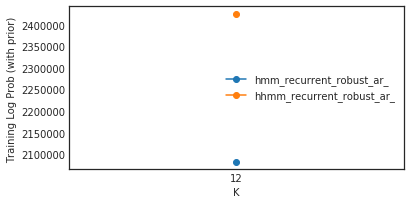

In [17]:
# Plot train and validation likelihoods
plt.figure(figsize=(6, 3))
for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_train_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][1][-1] for K in Ks]
        plt.plot(Ks, hmm_train_lls, '-o', label=hmm_results_prefix)
        
        hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
        hhmm_train_lls = [hhmm_results[hhmm_results_prefix + "K{}_eta{:1.0e}".format(K, etas[0])][1][-1] for K in Ks]
        plt.plot(Ks, hhmm_train_lls, '-o', label=hhmm_results_prefix)
        
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Training Log Prob (with prior) ")
plt.legend()

In [18]:
# Get the inferred states
hhmm, lls, val_ll = hhmm_results["hhmm_recurrent_robust_ar_K12_eta1e-01"]

In [21]:
z_infs = [hhmm.most_likely_states(x, input=u, tag=g) for g, x, u in zip(worms_and_groups, xs, us)]

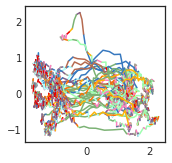

In [25]:
zplt.plot_2d_continuous_states(xs[6], z_infs[6])

/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


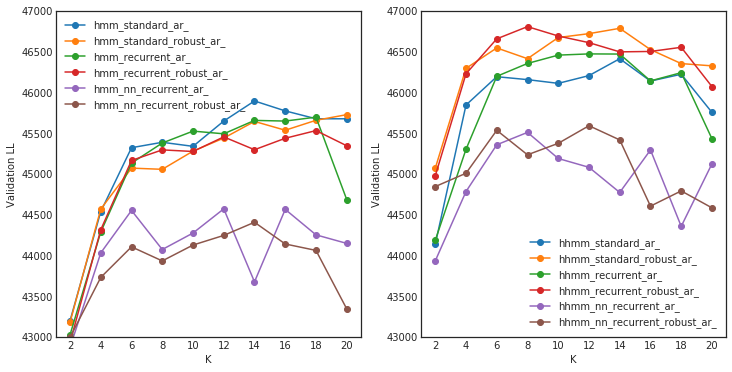

In [17]:
# Plot train and validation likelihoods

# num_bars = len(transitions) * len(observations)

plt.figure(figsize=(12, 6))
for transitions in transitionss:
    for observations in observationss:
        plt.subplot(121)
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hmm_val_lls, '-o', label=hmm_results_prefix)

        plt.subplot(122)
        hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix)

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.xlabel("K")
    plt.xticks(Ks)
    plt.ylabel("Validation LL")
    plt.ylim(43000, 47000)
    plt.legend()

# Fit the HHMM to the full train and validation data

In [18]:
def _fit_to_all_data(model):
    lps = model.fit(train_xs + val_xs, tags=train_tags + val_tags, method="em", num_em_iters=100, initialize=False)
    return model, lps

In [19]:
# Fit the HMMs
best_results = {}

for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
        best_K = Ks[np.argmax(hmm_val_lls)]
        
        # Fit the best model    
        results_name = "best_" + hmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K)
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hmm, _ = fit(hmm_results[hmm_results_prefix + "_K{}".format(best_K)][0])
        
        # Compute the log likelihood of the test data
        test_ll = hmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hmm, test_ll)
        
# Fit the HHMMs
for transitions in transitionss:
    for observations in observationss:
        hhmm_results_prefix = "hhmm_{}_{}".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
        best_K = Ks[np.argmax(hhmm_val_lls)]
        
        # Fit the best model    
        results_name = "best_" + hhmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K)
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hhmm, _ = fit(hhmm_results[hhmm_results_prefix + "_K{}".format(best_K)][0])
        
        # Compute the log likelihood of the test data
        test_ll = hhmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hhmm, test_ll)
        
with open(os.path.join(results_dir, "best_results.pkl"), "wb") as f:
    pickle.dump(best_results, f)

Fitting  best_hmm_standard_ar  with K =  14
Fitting  best_hmm_standard_robust_ar  with K =  20
Fitting  best_hmm_recurrent_ar  with K =  18
Fitting  best_hmm_recurrent_robust_ar  with K =  18
Fitting  best_hmm_nn_recurrent_ar  with K =  12
Fitting  best_hmm_nn_recurrent_robust_ar  with K =  14
Fitting  best_hhmm_standard_ar  with K =  14
Fitting  best_hhmm_standard_robust_ar  with K =  14
Fitting  best_hhmm_recurrent_ar  with K =  12
Fitting  best_hhmm_recurrent_robust_ar  with K =  8
Fitting  best_hhmm_nn_recurrent_ar  with K =  8
Fitting  best_hhmm_nn_recurrent_robust_ar  with K =  12


/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


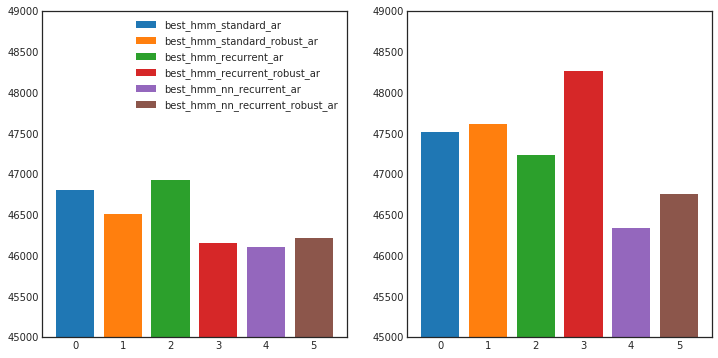

In [20]:
# Plot train and validation likelihoods

plt.figure(figsize=(12, 6))
i = 0
for transitions in transitionss:
    for observations in observationss:
        plt.subplot(121)
        hmm_results_prefix = "best_hmm_{}_{}".format(transitions, observations)
        plt.bar(i, best_results[hmm_results_prefix][1], label=hmm_results_prefix)
        plt.ylim(45000, 49000)
        
        plt.subplot(122)
        hhmm_results_prefix = "best_hhmm_{}_{}".format(transitions, observations)
        plt.bar(i, best_results[hhmm_results_prefix][1], label=hhmm_results_prefix)
        plt.ylim(45000, 49000)
        
        i += 1

plt.subplot(121)
plt.legend()

# Simulate from the model

In [21]:
def simulate_model(name, model, pad=3, N_smpls=20):
    # Get the inferred states
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
    model.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
    
    # Lower the noise
    model_low_noise = copy.deepcopy(model)
    model_low_noise.observations.inv_sigmas -= 4
    
    simulations = []

    for w in range(W):
        # Simulate N_smpls for this worm
        model_simulations_w = []
        for s in range(N_smpls):
            print("Model ", name, " Worm ", w, " sample ", s)
            # Sample data
            Tsmpl = Ts[w]
            zpre, xpre = z_infs[w][-pad:], xs[w][-pad:]
            zsmpl, xsmpl = model_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=w, with_noise=True)

            zsmpl = np.concatenate((zpre, zsmpl))
            xsmpl = np.concatenate((xpre, xsmpl))

            # Truncate to stable region
            unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 5, axis=1)]
            T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
            zsmpl = zsmpl[:T_stable]
            xsmpl = xsmpl[:T_stable]

            # Project into neural space
            ysmpl = xsmpl.dot(pca.components_) + pca.mean_

            # Append
            model_simulations_w.append((zsmpl, xsmpl, ysmpl))
            
        # Append this worm
        simulations.append(model_simulations_w)
        
    return simulations

In [25]:
simulations = {}
for name, (model, _) in best_results.items(): 
    print("Simulating ", name)
    _sim = cached(results_dir, name + "_sim")(simulate_model)
    simulations[name] = _sim(name, model)

Simulating  best_hmm_standard_ar
Simulating  best_hmm_standard_robust_ar
Simulating  best_hmm_recurrent_ar
Simulating  best_hmm_recurrent_robust_ar
Simulating  best_hmm_nn_recurrent_ar
Simulating  best_hmm_nn_recurrent_robust_ar
Simulating  best_hhmm_standard_ar
Simulating  best_hhmm_standard_robust_ar
Simulating  best_hhmm_recurrent_ar
Model  best_hhmm_recurrent_ar  Worm  0  sample  0
Model  best_hhmm_recurrent_ar  Worm  0  sample  1
Model  best_hhmm_recurrent_ar  Worm  0  sample  2
Model  best_hhmm_recurrent_ar  Worm  0  sample  3
Model  best_hhmm_recurrent_ar  Worm  0  sample  4
Model  best_hhmm_recurrent_ar  Worm  0  sample  5
Model  best_hhmm_recurrent_ar  Worm  0  sample  6
Model  best_hhmm_recurrent_ar  Worm  0  sample  7
Model  best_hhmm_recurrent_ar  Worm  0  sample  8
Model  best_hhmm_recurrent_ar  Worm  0  sample  9
Model  best_hhmm_recurrent_ar  Worm  0  sample  10
Model  best_hhmm_recurrent_ar  Worm  0  sample  11
Model  best_hhmm_recurrent_ar  Worm  0  sample  12
Model  b

Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  9
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  10
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  11
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  12
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  13
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  14
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  15
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  16
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  17
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  18
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  19
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  0
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  1
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  2
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  3
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  4
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  5
Model  best_hhmm_recu

Model  best_hhmm_nn_recurrent_ar  Worm  4  sample  18
Model  best_hhmm_nn_recurrent_ar  Worm  4  sample  19
Simulating  best_hhmm_nn_recurrent_robust_ar
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  0
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  1
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  2
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  3
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  4
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  5
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  6
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  7
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  8
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  9
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  10
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  11
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  12
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  13
Mod